## **Model 1. 신경망 Model with Keras** 

#### 전체 변수 중에서 상관관계가 0.75 이상인 변수들을 제거한 후 55개 변수 사용

#### 모델링 결과 month와 2month class의 분류 성능이 떨어진다는 점을 알 수 있었음
- 2month는 precision이 낮고, month는 recall이 낮음  

```
             precision    recall  f1-score   support
     2month       0.57      0.77      0.65     25000
      month       0.75      0.33      0.46     25000
   retained       0.76      0.80      0.78     25000
       week       0.78      0.89      0.83     25000
avg / total       0.71      0.70      0.68    100000
```

### Import packages & data

In [0]:
import warnings
warnings.simplefilter('ignore')

from sklearn.metrics import classification_report, confusion_matrix
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import *
from sklearn.model_selection import train_test_split
from keras.utils import np_utils

##### f1 score를 train과정에서 확인하기 위한 함수

In [0]:
from keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

### Feature Variables

In [0]:
train_55 = pd.read_csv("../data/train_merged_55vars.csv")
train_55.shape

(100000, 57)

In [0]:
# 사용변수 list
vars55 = list(train_55.loc[:,"cnt_dt":].columns)
vars55

['cnt_dt',
 'play_time',
 'play_cnt_8wk',
 'npc_exp',
 'npc_hongmun',
 'quest_hongmun',
 'item_hongmun',
 'get_money',
 'duel_win',
 'partybattle_win',
 'cnt_clear_inzone_solo',
 'cnt_clear_inzone_skilled',
 'cnt_clear_raid_light',
 'cnt_clear_bam',
 'normal_chat',
 'whisper_chat',
 'district_chat',
 'party_chat',
 'guild_chat',
 'faction_chat',
 'gathering_cnt',
 'making_cnt',
 'guild_counts',
 'guild_size',
 'party_cnt',
 'party_78_ratio',
 'party_cnt_std',
 'last_payment_week',
 'pay_amount_w1',
 'pay_amount_w2',
 'pay_amount_w3',
 'pay_amount_w4',
 'pay_amount_w5',
 'pay_amount_w6',
 'pay_amount_w7',
 'pay_amount_w8',
 'pay_amount_std',
 'buy_cnt',
 'sell_cnt_w1',
 'sell_cnt_w5',
 'sell_cnt_w8',
 'sell_cnt_accessory',
 'sell_cnt_costume',
 'sell_cnt_gem',
 'sell_cnt_weapon',
 'buy_cnt_accessory',
 'buy_cnt_costume',
 'buy_cnt_gem',
 'buy_cnt_weapon',
 'sell_amount_weapon',
 'buy_amount_money',
 'buy_amount_weapon',
 'sell_1st_week',
 'sell_last_week',
 'buy_last_week']

### Data Preprocessing

In [0]:
X = train_55.drop(["acc_id", "label"], axis=1)
X.shape

(100000, 55)

In [0]:
y = pd.DataFrame(train_55["label"])
y.shape

(100000, 1)

#### label encoding

In [0]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(y)
le.classes_

array(['2month', 'month', 'retained', 'week'], dtype=object)

In [0]:
yy = le.transform(y)
yy

array([3, 3, 3, ..., 2, 2, 2], dtype=int64)

#### label binarizer

In [0]:
y_1 = np_utils.to_categorical(yy, 4)

#### create test dataset for validation

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y_1, test_size=0.2, random_state=1, shuffle=True)

In [0]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(80000, 55)
(80000, 4)
(20000, 55)
(20000, 4)


## Modeling 

### model1: 

In [0]:
np.random.seed(0)

model1 = Sequential()
model1.add(Dense(150, input_dim=55, activation="relu", kernel_initializer="glorot_uniform"))
model1.add(Dense(4, activation="tanh", kernel_initializer="glorot_uniform"))
model1.compile(optimizer=Adadelta(lr=0.5), loss='mean_squared_error', metrics=[f1])

In [0]:
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 150)               8400      
_________________________________________________________________
dense_12 (Dense)             (None, 4)                 604       
Total params: 9,004
Trainable params: 9,004
Non-trainable params: 0
_________________________________________________________________


In [0]:
%%time
hist1 = model1.fit(X_train, y_train, epochs=1000, batch_size=100, validation_data=(X_test, y_test), verbose=2)

Train on 80000 samples, validate on 20000 samples
Epoch 1/1000
 - 1s - loss: 0.3593 - f1: 0.4403 - val_loss: 0.2624 - val_f1: 0.5201
Epoch 2/1000
 - 1s - loss: 0.2918 - f1: 0.4733 - val_loss: 0.2481 - val_f1: 0.4922
Epoch 3/1000
 - 1s - loss: 0.2738 - f1: 0.4881 - val_loss: 0.2643 - val_f1: 0.4650
Epoch 4/1000
 - 1s - loss: 0.2658 - f1: 0.4948 - val_loss: 0.2756 - val_f1: 0.5169
Epoch 5/1000
 - 1s - loss: 0.2606 - f1: 0.5008 - val_loss: 0.2844 - val_f1: 0.4890
Epoch 6/1000
 - 2s - loss: 0.2559 - f1: 0.5067 - val_loss: 0.2426 - val_f1: 0.5365
Epoch 7/1000
 - 1s - loss: 0.2518 - f1: 0.5095 - val_loss: 0.2266 - val_f1: 0.4762
Epoch 8/1000
 - 1s - loss: 0.2472 - f1: 0.5143 - val_loss: 0.2989 - val_f1: 0.5245
Epoch 9/1000
 - 1s - loss: 0.2422 - f1: 0.5163 - val_loss: 0.2151 - val_f1: 0.5366
Epoch 10/1000
 - 2s - loss: 0.2368 - f1: 0.5236 - val_loss: 0.2835 - val_f1: 0.4740
Epoch 11/1000
 - 1s - loss: 0.2315 - f1: 0.5246 - val_loss: 0.2090 - val_f1: 0.5314
Epoch 12/1000
 - 1s - loss: 0.2265 

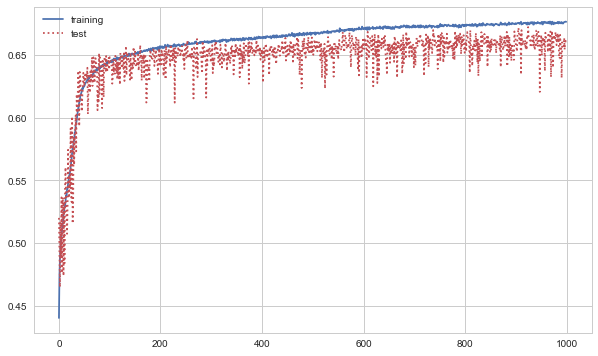

In [0]:
plt.figure(figsize=(10, 6))
plt.plot(hist1.history['f1'], 'b-', label="training")
plt.plot(hist1.history['val_f1'], 'r:', label="test")
plt.legend()
plt.show()

In [0]:
model1.save("model_all_55var_1.hdf5")

### performance check

#### (1) 전체 train data 사용 performance

In [0]:
y_pred_train = model1.predict_classes(X, verbose=0)
y_pred_train = le.inverse_transform(y_pred_train)
y = le.inverse_transform(y)

In [0]:
y_pred_train_df = pd.DataFrame(y_pred_train).rename(columns={0:"label"})
y_pred_train_df.groupby("label").size()

label
2month      33968
month       11112
retained    26397
week        28523
dtype: int64

In [0]:
print(confusion_matrix(y, y_pred_train_df))

[[19209   968  3341  1482]
 [10836  8364  1937  3863]
 [ 3531   490 20038   941]
 [  392  1290  1081 22237]]


In [0]:
print(classification_report(y, y_pred_train_df))

             precision    recall  f1-score   support

     2month       0.57      0.77      0.65     25000
      month       0.75      0.33      0.46     25000
   retained       0.76      0.80      0.78     25000
       week       0.78      0.89      0.83     25000

avg / total       0.71      0.70      0.68    100000



#### (2) test data 자율평가 performance (전체 data의 20%로 채점)

##### 제출결과: f1-score = 0.631 

In [0]:
test_55 = pd.read_csv("../data/test_merged_55vars.csv")
test_55.shape

(40000, 56)

In [0]:
X_test55 = test_55.drop(["acc_id"], axis=1)

In [0]:
y_pred_55 = model1.predict_classes(X_test55, verbose=0)
y_pred_55 = le.inverse_transform(y_pred_55)

In [0]:
label = pd.DataFrame(y_pred_55)
label.rename(columns={0:"label"}, inplace=True)
label.groupby("label").size().reset_index()

,label,0
0,2month,13465
1,month,4508
2,retained,10531
3,week,11496


In [0]:
test_submission = pd.DataFrame(columns = ["acc_id", "label"])
test_submission["acc_id"] = test_55["acc_id"]
test_submission["label"] = y_pred_55

In [0]:
test_submission.to_csv("../data/submission/20180809_55vars_keras.csv", index=False)

In [0]:
test_submission.groupby("label").size()

label
2month      13465
month        4508
retained    10531
week        11496
dtype: int64

### model2: hidden layer 추가

In [0]:
np.random.seed(0)

model2 = Sequential()
model2.add(Dense(50, input_dim=55, kernel_initializer="glorot_uniform", activation="tanh"))
model2.add(Dense(50, kernel_initializer="glorot_uniform", activation="tanh"))
model2.add(Dense(4, activation="tanh"))
model2.compile(optimizer=Adadelta(lr=0.5), loss='mean_squared_error', metrics=[f1])

In [0]:
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_48 (Dense)             (None, 50)                2800      
_________________________________________________________________
dense_49 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_50 (Dense)             (None, 4)                 204       
Total params: 5,554
Trainable params: 5,554
Non-trainable params: 0
_________________________________________________________________


In [0]:
%%time
hist2 = model2.fit(X_train, y_train, epochs=1000, batch_size=100, 
                 validation_data=(X_test, y_test), verbose=2)

Train on 80000 samples, validate on 20000 samples
Epoch 1/1000
 - 2s - loss: 0.1487 - f1: 0.4974 - val_loss: 0.1281 - val_f1: 0.5490
Epoch 2/1000
 - 2s - loss: 0.1259 - f1: 0.5529 - val_loss: 0.1238 - val_f1: 0.5876
Epoch 3/1000
 - 1s - loss: 0.1226 - f1: 0.5625 - val_loss: 0.1208 - val_f1: 0.5616
Epoch 4/1000
 - 1s - loss: 0.1208 - f1: 0.5694 - val_loss: 0.1198 - val_f1: 0.5982
Epoch 5/1000
 - 1s - loss: 0.1196 - f1: 0.5757 - val_loss: 0.1197 - val_f1: 0.5975
Epoch 6/1000
 - 1s - loss: 0.1186 - f1: 0.5806 - val_loss: 0.1172 - val_f1: 0.5912
Epoch 7/1000
 - 1s - loss: 0.1179 - f1: 0.5844 - val_loss: 0.1171 - val_f1: 0.5715
Epoch 8/1000
 - 1s - loss: 0.1172 - f1: 0.5882 - val_loss: 0.1175 - val_f1: 0.6063
Epoch 9/1000
 - 1s - loss: 0.1168 - f1: 0.5905 - val_loss: 0.1165 - val_f1: 0.5884
Epoch 10/1000
 - 1s - loss: 0.1163 - f1: 0.5914 - val_loss: 0.1156 - val_f1: 0.5534
Epoch 11/1000
 - 1s - loss: 0.1158 - f1: 0.5938 - val_loss: 0.1159 - val_f1: 0.6049
Epoch 12/1000
 - 1s - loss: 0.1154 

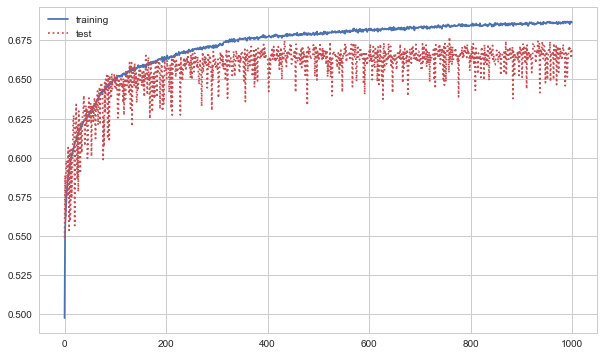

In [0]:
plt.figure(figsize=(10, 6))
plt.plot(hist2.history['f1'], 'b-', label="training")
plt.plot(hist2.history['val_f1'], 'r:', label="test")
plt.legend()
plt.show()

### Prediction

#### Train Prediction

In [0]:
y_pred_train_2 = model2.predict_classes(X, verbose=0)
y_pred_train_2 = le.inverse_transform(y_pred_train_2)

In [0]:
y_pred_train_df_2 = pd.DataFrame(y_pred_train).rename(columns={0:"label"})
y_pred_train_df_2.groupby("label").size()

label
2month      33334
month       10699
retained    26359
week        29608
dtype: int64

#### Test prediction

In [0]:
test_55 = pd.read_csv("../data/test_merged_55vars.csv")
test_55.shape

(40000, 56)

In [0]:
X_test55 = test_55.drop(["acc_id"], axis=1)

In [0]:
y_pred_55_2 = model2.predict_classes(X_test55, verbose=0)
y_pred_55_2 = le.inverse_transform(y_pred_55_2)

In [0]:
test_submission = pd.DataFrame(columns = ["acc_id", "label"])
test_submission["acc_id"] = test_55["acc_id"]
test_submission["label"] = y_pred_55_2

In [0]:
test_submission.to_csv("../data/submission/20180810_55vars_keras.csv", index=False)

### Performance check

#### (1) 전체 train data 사용 performance

In [0]:
print(confusion_matrix(y, y_pred_train_df_2))

[[19209   968  3341  1482]
 [10836  8364  1937  3863]
 [ 3531   490 20038   941]
 [  392  1290  1081 22237]]


In [0]:
print(classification_report(y, y_pred_train_df_2))

             precision    recall  f1-score   support

     2month       0.57      0.77      0.65     25000
      month       0.75      0.33      0.46     25000
   retained       0.76      0.80      0.78     25000
       week       0.78      0.89      0.83     25000

avg / total       0.71      0.70      0.68    100000



#### (2) test data 자율평가 performance (전체 data의 20%로 채점)

##### 제출결과: f1-score = 0.6397
![result](result_model1.png)

In [0]:
label = pd.DataFrame(y_pred_55_2)
label.rename(columns={0:"label"}, inplace=True)
label.groupby("label").size().reset_index()

,label,0
0,2month,13421
1,month,5189
2,retained,10293
3,week,11097
